# Extreme-Correction applied to Hs and Tp

Extreme correction technique applied to Hs and Tp from Santoña.

In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

os.chdir(r"c:\Users\user\Victor\Trabajo\ExtremeCorrection")
from src.extr_corr import ExtremeCorrection

# Load Data

In [2]:
historical_dataset = xr.open_dataset("Data/DatosJared/Wave_families_santona_daily.nc")
sampled_dataset = xr.open_dataset("Data/DatosJared/simulated_waves.nc").rename({"bulk_Hs": "Hs", "bulk_Tp": "Tp", "bulk_Dir": "Dir"})

In [3]:
historical_dataset

<xarray.Dataset>
Dimensions:      (time: 14610)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2018-12-31
Data variables:
    sea_Hs       (time) float32 ...
    sea_Tp       (time) float32 ...
    sea_Dir      (time) float32 ...
    swell_1_Hs   (time) float64 ...
    swell_1_Tp   (time) float64 ...
    swell_1_Dir  (time) float64 ...
    Hs           (time) float32 ...
    Tp           (time) float32 ...
    Dir          (time) float32 ...
    bmus         (time) int64 ...

In [4]:
sampled_dataset

<xarray.Dataset>
Dimensions:  (n_sim: 1, time: 36891)
Coordinates:
  * time     (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2100-01-01
Dimensions without coordinates: n_sim
Data variables:
    DWT      (n_sim, time) int64 ...
    Hs       (n_sim, time) float64 ...
    Tp       (n_sim, time) float64 ...
    Dir      (n_sim, time) float64 ...

Asumo que bmus tiene los WT, sino habria que cogerlos de la siguiente forma:

In [5]:
df_hist = historical_dataset.to_dataframe().loc[:,["Hs", "Tp", "Dir", "bmus"]]
df_hist["yyyy"] = df_hist.index.year
df_hist["mm"] = df_hist.index.month
df_hist["dd"] = df_hist.index.day
df_hist = df_hist.reset_index()
df_hist["time"] = df_hist.index / 365.25
df_hist.head()

,time,Hs,Tp,Dir,bmus,yyyy,mm,dd
0,0.000000,1.023583,4.836266,185.625000,26,1979,1,1
1,0.002738,1.341333,5.067072,89.291664,26,1979,1,2
2,0.005476,1.855333,6.305674,126.416664,8,1979,1,3
3,0.008214,4.830250,11.519656,282.291656,27,1979,1,4
4,0.010951,2.902167,11.920074,305.916656,23,1979,1,5


In [6]:
df_sim = sampled_dataset.sel(n_sim=0).to_dataframe().loc[:,["Hs", "Tp", "Dir", "DWT"]]
df_sim["yyyy"] = df_sim.index.year
df_sim["mm"] = df_sim.index.month
df_sim["dd"] = df_sim.index.day
df_sim = df_sim.reset_index()
df_sim["time"] = df_sim.index / 365.25
df_sim.head()

,time,Hs,Tp,Dir,DWT,yyyy,mm,dd
0,0.000000,1.750975,8.529534,283.245014,31,1999,1,1
1,0.002738,1.627966,8.854106,299.305291,31,1999,1,2
2,0.005476,2.761744,9.576388,329.714930,29,1999,1,3
3,0.008214,2.325261,14.954787,306.216905,15,1999,1,4
4,0.010951,1.819668,16.823529,288.421431,3,1999,1,5


# Hs

In [7]:
config = {
    'var': "Hs",
    'time_var': 'time',
    'yyyy_var': 'yyyy',
    'mm_var': 'mm',
    'dd_var': 'dd',
    'freq': 365.25,
    'folder': 'Figures/Santona/Hs_Santona_Hs'
}

pot_config = {
    'n0': 10,
    'min_peak_distance': 2,
    'init_threshold': 0.0,
    'siglevel': 0.01,
    'plot_flag': True
}

extr_corr_complete = ExtremeCorrection(
    data_hist = df_hist,
    data_sim = df_sim[:-1],
    config=config,
    pot_config=pot_config,
    method="POT",
    conf_level=0.95,
    random_state=0
)

Poisson parameters difference: 19.6837083220385


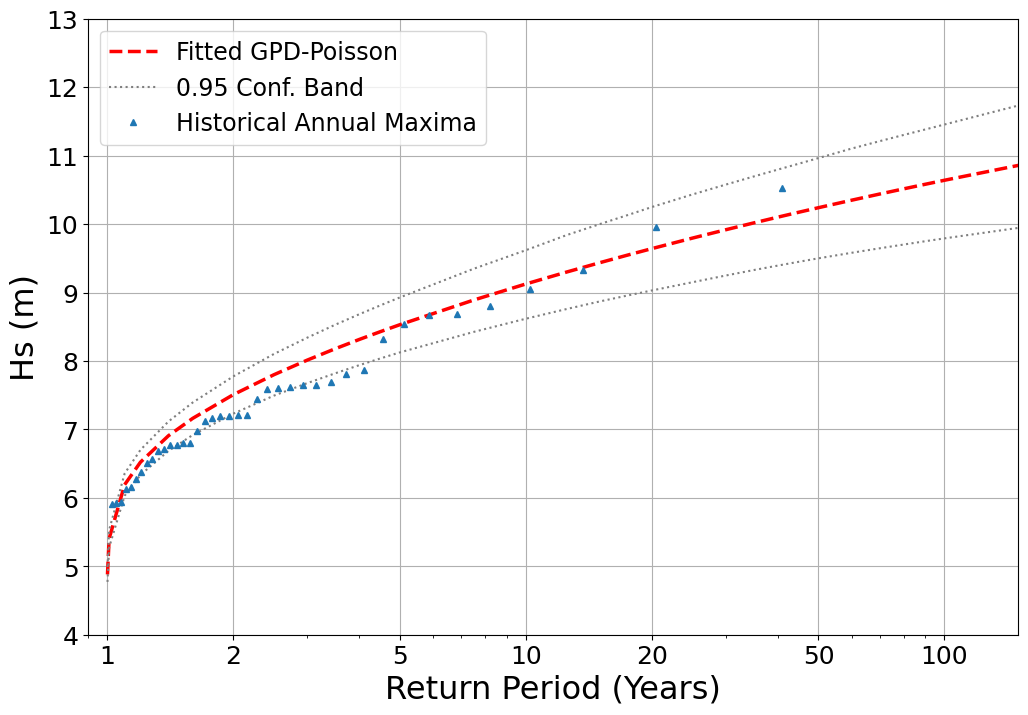

In [73]:
extr_corr_complete.apply_correction(fit_diag=True)
fig, ax = extr_corr_complete.return_period_plot(conf_int_method="bootstrap")
ax.set_ylim(4, 13)
ax.set_xlim(0.9,150)
ax.set_ylabel("Hs (m)", fontsize=23)
ax.set_xlabel("Return Period (Years)", fontsize=23)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
plt.savefig("Figures/Santona/Hs_Santona_Hs/Hs_Historical_ReturnPeriod.png", dpi=300, bbox_inches="tight")
plt.show()

In [9]:
extr_corr_complete.test_dist()

{'Statistic': 33.58178008820684, 'P-value': 4.58732041241916e-09}

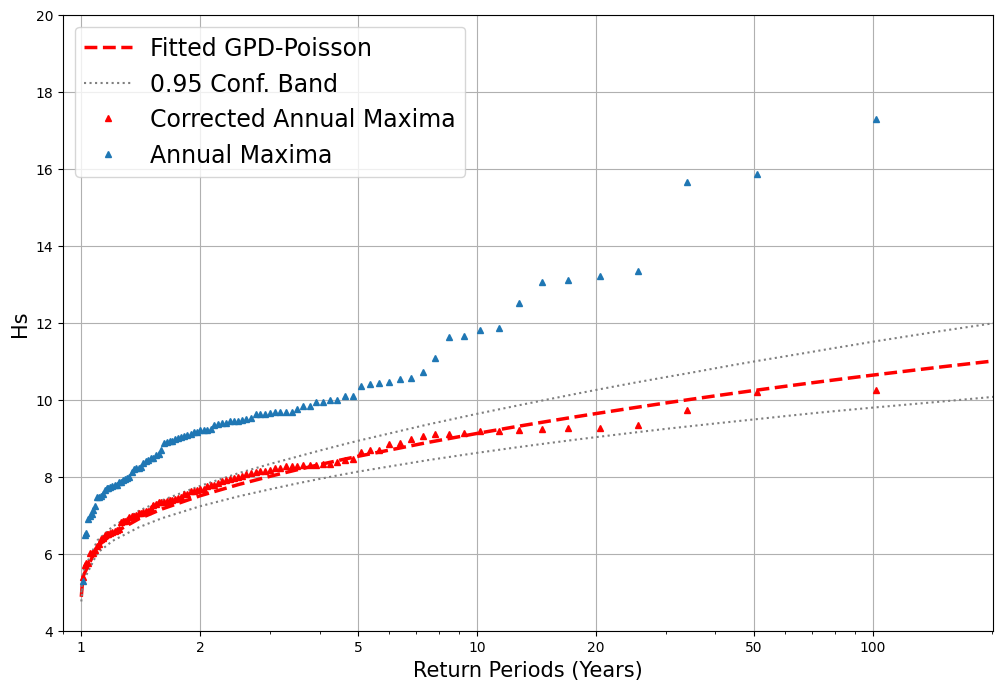

In [10]:
extr_corr_complete.apply_sim_correction()
fig, ax = extr_corr_complete.sim_return_period_plot(show_corrected=True, show_uncorrected=True)
# extr_corr_complete.sim_return_period_plot(show_corrected=True, show_uncorrected=False)
# extr_corr_complete.sim_return_period_plot(show_corrected=False, show_uncorrected=True)

ax.set_ylim(4, 20)
plt.savefig("Figures/Santona/Hs_Santona_Hs/Hs_Simulation_ReturnPeriod_Corr_NoCorr.png", dpi=300, bbox_inches="tight")
plt.show()

In [11]:
extr_corr_complete.parameters

[1.5383334159851074, 1.7846657694666397, -0.13595930499696124]

In [12]:
extr_corr_complete.poiss_parameter, extr_corr_complete.sim_poiss_parameter

(60.0, 79.6837083220385)

In [13]:
extr_corr_complete.sim_poiss_parameter/extr_corr_complete.poiss_parameter

1.3280618053673083

## Loop over correction

In [14]:
dict_maximos_corregidos_Hs = {}
dict_sim_pit_corrected_Hs = {}
for i in range(100):
    
    extr_corr_complete.apply_sim_correction(random_state=i)   # Apply the correction in the simulated data
    # if i == 0:
    #     extr_corr.sim_return_period_plot(show_corrected=True, show_uncorrected=True)                        # Default to plot the corrected and no corrected data
    #     fitted_gev = extr_corr.
    
    
    dict_maximos_corregidos_Hs[i] = extr_corr_complete.sim_max_data_corrected_sorted
    dict_sim_pit_corrected_Hs[i] = extr_corr_complete.sim_pit_data_corrected

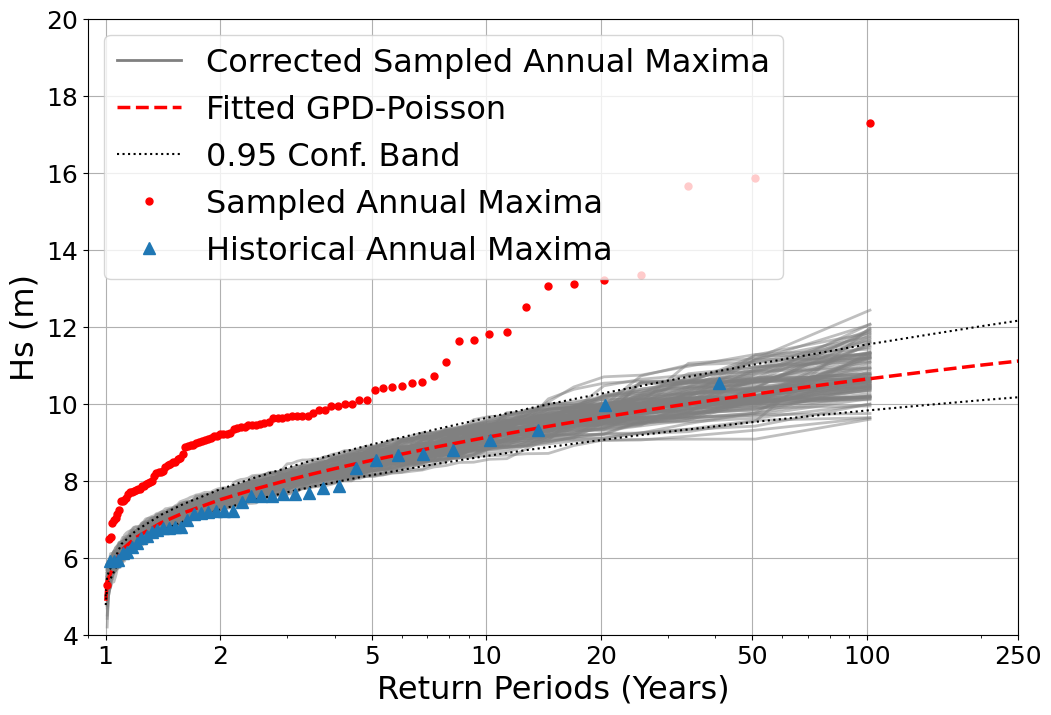

In [72]:
# import numdifftools as ndt
# from src.gev_utils import dq_gev, nll_gev
from src.constants import LABEL_FONTSIZE, LEGEND_FONTSIZE
# # Plot

# x_vals_gev_sim = np.linspace(stats.genextreme.ppf(1e-8, extr_corr.parameters[2], loc=extr_corr.parameters[0], scale=extr_corr.parameters[1]), stats.genextreme.ppf(1-1/1000, extr_corr.parameters[2], loc=extr_corr.parameters[0], scale=extr_corr.parameters[1]), 1000)
# # Return period from GEV fitted
# gev_probs_fitted = stats.genextreme.cdf(x_vals_gev_sim, extr_corr.parameters[2], loc=extr_corr.parameters[0], scale=extr_corr.parameters[1])
# T_gev_fitted = 1.0 / (1.0 - gev_probs_fitted) #*(40/len(max_data_hist[wt]))#(10000/n_peaks)

# # Corrected peaks: re-check CDF and return periods
# ecdf_annmax_probs_corrected_sim = stats.genextreme.cdf(
#     stats.genextreme.ppf(extr_corr.ecdf_annmax_probs_sim, extr_corr.parameters[2], loc=extr_corr.parameters[0], scale=extr_corr.parameters[1]),
#     extr_corr.parameters[2], loc=extr_corr.parameters[0], scale=extr_corr.parameters[1]
# )
# T_ev_corrected_sim = 1.0 / (1.0 - ecdf_annmax_probs_corrected_sim) #*(40/len(max_data_hist[wt]))#(10000/n_peaks)

# # Daily corrected data
# ecdf_pt_probs_corrected_sim = np.arange(1, extr_corr.n_sim_pit + 1) / (extr_corr.n_sim_pit + 1)
# T_pt_corrected_sim = 1.0 / (1.0 - ecdf_pt_probs_corrected_sim) / extr_corr.freq #/ n_return_period[wt] 

# # POT (uncorrected)
# T_pot_sim = 1.0 / (1.0 - extr_corr.ecdf_annmax_probs_sim) #*(40/len(max_data_hist[wt]))#(10000/n_peaks)

# # Confidence intervals
# dqgev_sim = dq_gev(gev_probs_fitted, p=[extr_corr.parameters[0], extr_corr.parameters[1], extr_corr.parameters[2]])
# aux_fun = lambda x: nll_gev(extr_corr.max_data, x)
# hess = ndt.Hessian(aux_fun, step=1e-4)  # Añado el step para que no de problemas de inestabilidad
# hessians_gev_sim = hess([extr_corr.parameters[0], extr_corr.parameters[1], extr_corr.parameters[2]])
# invI0_gev_sim = np.linalg.inv(hessians_gev_sim)

# stdDq_gev_sim = np.sqrt(np.sum((dqgev_sim.T@invI0_gev_sim) * dqgev_sim.T, axis=1)) # Es lo mismo 
# stdup_gev_sim = x_vals_gev_sim + stdDq_gev_sim*stats.norm.ppf(1-(1-extr_corr.conf)/2,0,1)
# stdlo_gev_sim = x_vals_gev_sim - stdDq_gev_sim*stats.norm.ppf(1-(1-extr_corr.conf)/2,0,1)


fig = plt.figure(figsize=(12,8))
ax= fig.add_subplot()

# Corrected AM
ax.semilogx(extr_corr_complete.T_annmax_sim, dict_maximos_corregidos_Hs[0], color = 'gray', linewidth=2, alpha=0.5,label='Corrected Sampled Annual Maxima')
for i in range(1,100):
    ax.semilogx(extr_corr_complete.T_annmax_sim, dict_maximos_corregidos_Hs[i], color = 'gray', linewidth=2, alpha=0.5)

# Fitted GPD-Poisson
ax.semilogx(extr_corr_complete.ci_T_years, extr_corr_complete.x_vals_gpd_poiss_sim, color = 'red',linestyle='dashed', linewidth=2.5, label='Fitted GPD-Poisson')
# Confidence interval for fitted GPD-Poisson
ax.semilogx(extr_corr_complete.ci_T_years, extr_corr_complete.upper_pot_ci_return, color = "black",linestyle='dotted', label=f'{extr_corr_complete.conf} Conf. Band')
ax.semilogx(extr_corr_complete.ci_T_years, extr_corr_complete.lower_pot_ci_return, color = "black",linestyle='dotted')


ax.semilogx(extr_corr_complete.T_annmax_sim, extr_corr_complete.sim_max_data_sorted, color="red", linewidth=0, marker='o',markersize=5, label='Sampled Annual Maxima')

ax.semilogx(extr_corr_complete.T_annmax, extr_corr_complete.max_data_sorted, color="tab:blue", linewidth=0, marker='^',markersize=8, label='Historical Annual Maxima')

ax.set_xlabel("Return Periods (Years)", fontsize=23)
ax.set_ylabel(f"{extr_corr_complete.var} (m)", fontsize=23)
# ax.set_title(f"Simulated Return Period ({self.var})", fontsize=TITLE_FONTSIZE)
ax.set_xscale('log')
ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000])
# ax.set_xticklabels([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000], fontsize=15)
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
# ax.set_yticklabels(ax.set, fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.set_xlim(left=0.9,right=250)
ax.set_ylim(bottom=4, top=20)
leg = ax.legend(loc='best', ncol=1, fontsize=23)
for lh in leg.legend_handles:
    lh.set_alpha(1)
# ax.legend(loc='upper left', fontsize=LEGEND_FONTSIZE)
ax.grid()
plt.savefig("Figures/Santona/Hs_Santona_Hs/Hs_ReturnPeriod_Simulated_100sims.png", dpi=300, bbox_inches="tight")
plt.show()

In [16]:
correlation_hs = extr_corr_complete.correlation()
correlation_hs

{'Spearman': 0.9999999999999998, 'Kendall': 1.0, 'Pearson': 0.9923960375384291}

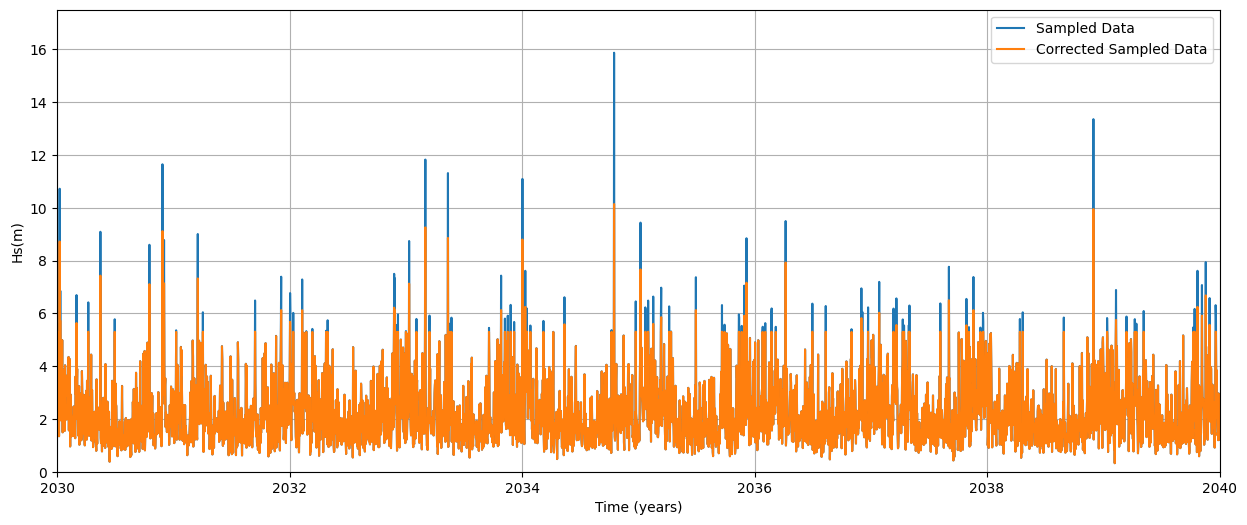

In [17]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot()

ax.plot(df_sim["time"].values[:-1]+df_sim["yyyy"].min(), extr_corr_complete.sim_pit_data, label="Sampled Data", color="tab:blue")
ax.plot(df_sim["time"].values[:-1]+df_sim["yyyy"].min(), extr_corr_complete.sim_pit_data_corrected, label="Corrected Sampled Data", color="tab:orange")
# ax.hlines(5.25, xmin=2033, xmax=2035, color="black", linestyles="--")
ax.set_xlim(2030, 2040)
ax.set_ylim(0, 17.5)
ax.set_xlabel("Time (years)")
ax.set_ylabel("Hs(m)")
ax.grid()
ax.legend()
plt.savefig("Figures/Santona/Hs_Santona_Hs/Hs_SimTimeSeries_Corr_NoCorr.png", dpi=300, bbox_inches="tight")
plt.show()

## Simulated Poisson parameter change 

In [18]:
sim_poiss_param_100_hs = np.zeros(100)
for i in range(100):
    sim_pot_corrected_hs, _ = extr_corr_complete.obtain_pots(
                dict_sim_pit_corrected_Hs[i],
                threshold=extr_corr_complete.opt_threshold,
                n0 = extr_corr_complete.pot_config['n0'],
                min_peak_distance=extr_corr_complete.pot_config['min_peak_distance'],
                siglevel = extr_corr_complete.pot_config['siglevel'],
                plot_flag = extr_corr_complete.pot_config['plot_flag'],
                optimize_threshold=False
            )
    sim_poiss_param_100_hs[i] = sim_pot_corrected_hs.size / extr_corr_complete.time_interval_sim

In [19]:
print(np.mean(sim_poiss_param_100_hs), np.std(sim_poiss_param_100_hs))

79.57489570344268 1.4927652208139202


In [20]:
extr_corr_complete.sim_poiss_parameter

79.6837083220385

In [21]:
extr_corr_complete.poiss_parameter

60.0

Ver el número de datos diarios que hay entre cada bloque y como cambian los bloques

In [22]:
bloques = {}
for j in range(extr_corr_complete.sim_max_data_sorted.size):
    if j == 0:
        bloques[j] = (
            sum((extr_corr_complete.sim_pit_data >= min(extr_corr_complete.sim_pit_data)) & (extr_corr_complete.sim_pit_data < extr_corr_complete.sim_max_data_sorted[j])), 
            (min(extr_corr_complete.sim_pit_data), extr_corr_complete.sim_max_data_sorted[j]), 
            (min(extr_corr_complete.sim_pit_data_corrected), extr_corr_complete.sim_max_data_corrected_sorted[j])
            )
    else:
        bloques[j] = (
            sum((extr_corr_complete.sim_pit_data >= extr_corr_complete.sim_max_data_sorted[j-1]) & (extr_corr_complete.sim_pit_data < extr_corr_complete.sim_max_data_sorted[j])), 
            (extr_corr_complete.sim_max_data_sorted[j-1], extr_corr_complete.sim_max_data_sorted[j]), 
            (extr_corr_complete.sim_max_data_corrected_sorted[j-1], extr_corr_complete.sim_max_data_corrected_sorted[j])
            )

In [23]:
bloques

{0: (35736,
  (0.17059068486300943, 5.301258173546213),
  (0.17059068486300943, 5.294557724406874)),
 1: (694,
  (5.301258173546213, 6.4973464443083495),
  (5.294557724406874, 5.304926188709102)),
 2: (12,
  (6.4973464443083495, 6.528554942439624),
  (5.304926188709102, 5.536184724974024)),
 3: (117,
  (6.528554942439624, 6.901576514188907),
  (5.536184724974024, 5.758958569680151)),
 4: (21,
  (6.901576514188907, 6.977285020826242),
  (5.758958569680151, 5.861933162829918)),
 5: (9,
  (6.977285020826242, 7.023372717237794),
  (5.861933162829918, 5.904700658899709)),
 6: (24,
  (7.023372717237794, 7.143926407312166),
  (5.904700658899709, 5.922849276305563)),
 7: (18,
  (7.143926407312166, 7.236446723128276),
  (5.922849276305563, 6.118001301286638)),
 8: (47,
  (7.236446723128276, 7.467809395689405),
  (6.118001301286638, 6.126343484066921)),
 9: (3,
  (7.467809395689405, 7.481819293345467),
  (6.126343484066921, 6.206037645852525)),
 10: (3,
  (7.481819293345467, 7.495418268629498),


In [24]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

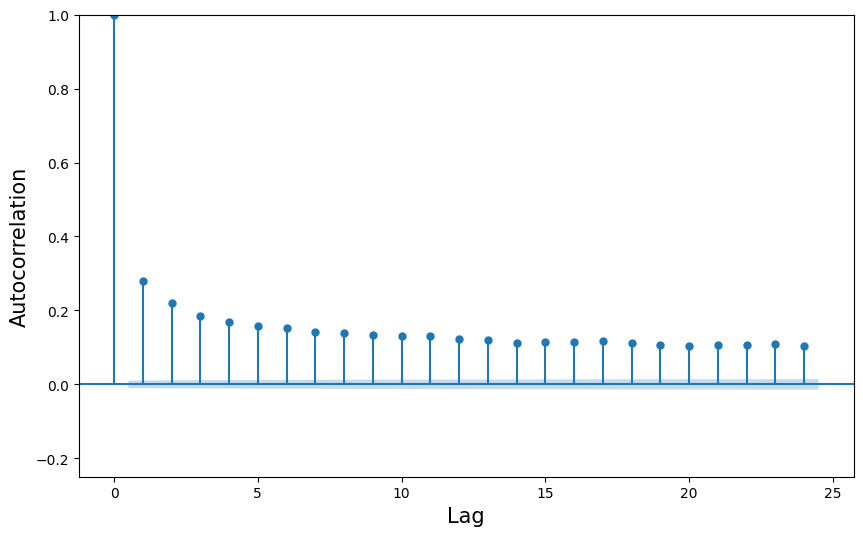

In [25]:
plt.rc("figure", figsize=(10,6))
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
plot_acf(extr_corr_complete.sim_pit_data, ax=ax, lags=24, alpha=0.05)
ax.set_title("")
ax.set_xlabel("Lag", fontsize=15)
ax.set_ylabel("Autocorrelation", fontsize=15)
ax.set_ylim(-0.25)
plt.savefig("Figures/Santona/Hs_Santona_Hs/Hs_ACF_sim.png", dpi=300, bbox_inches='tight')
plt.show()

In [26]:
acf_hist, confint_hist = acf(extr_corr_complete.sim_pit_data, nlags=7, alpha=0.05)
acf_sim, confint_sim = acf(extr_corr_complete.sim_pit_data_corrected, nlags=7, alpha=0.05)

In [27]:
import scipy.stats as stats
stats.pearsonr(acf_hist, acf_sim)

PearsonRResult(statistic=0.9999539860640362, pvalue=2.4355282542281483e-13)

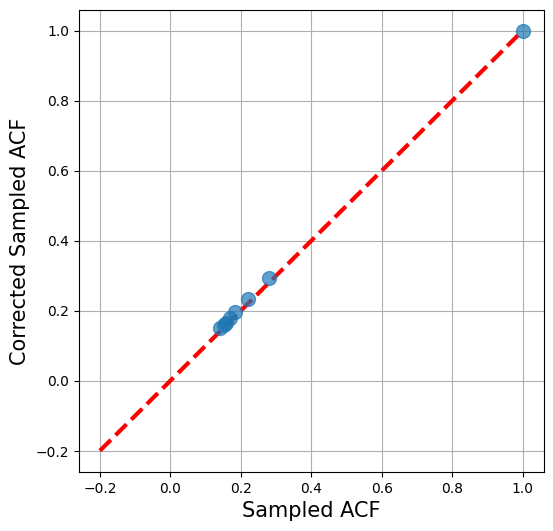

In [28]:
plt.figure(figsize=(6,6))
plt.plot([-0.2,1],[-0.2,1], 'r--', linewidth=3)
plt.plot(acf_hist, acf_sim, linewidth=0, marker="o", markersize=10, alpha=0.7)
plt.grid()
plt.xlabel("Sampled ACF", fontsize=15)
plt.ylabel("Corrected Sampled ACF", fontsize=15)
plt.savefig("Figures/Santona/Hs_Santona_Hs/Hs_ACF_scatter.png", dpi=300, bbox_inches='tight')
plt.show()

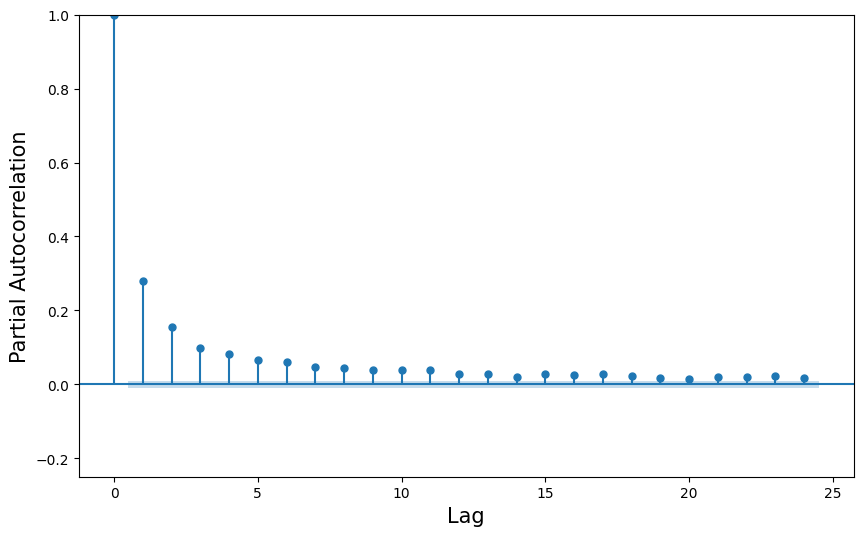

In [29]:
plt.rc("figure", figsize=(10,6))
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
plot_pacf(extr_corr_complete.sim_pit_data, ax=ax, lags=24, alpha=0.05)
ax.set_title("")
ax.set_xlabel("Lag", fontsize=15)
ax.set_ylabel("Partial Autocorrelation", fontsize=15)
ax.set_ylim(-0.25)
plt.savefig("Figures/Santona/Hs_Santona_Hs/Hs_PACF_sim.png", dpi=300, bbox_inches='tight')
plt.show()

In [30]:
pacf_hist, pconfint_hist = pacf(extr_corr_complete.sim_pit_data, nlags=7, alpha=0.05)
pacf_sim, pconfint_sim = pacf(extr_corr_complete.sim_pit_data_corrected, nlags=7, alpha=0.05)

In [31]:
stats.pearsonr(pacf_hist, pacf_sim)

PearsonRResult(statistic=0.9998867402154517, pvalue=3.6318701288143605e-12)

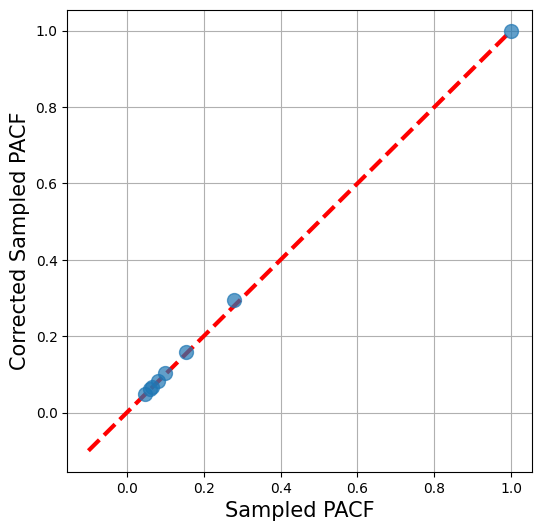

In [32]:
plt.figure(figsize=(6,6))
plt.plot([-0.1,1],[-0.1,1], 'r--', linewidth=3)
plt.plot(pacf_hist, pacf_sim, linewidth=0, marker="o", markersize=10, alpha=0.7)
plt.grid()
plt.xlabel("Sampled PACF", fontsize=15)
plt.ylabel("Corrected Sampled PACF", fontsize=15)
plt.savefig("Figures/Santona/Hs_Santona_Hs/Hs_PACF_scatter.png", dpi=300, bbox_inches='tight')
plt.show()

# Tp

In [33]:
config_tp = {
    'var': "Tp",
    'time_var': 'time',
    'yyyy_var': 'yyyy',
    'mm_var': 'mm',
    'dd_var': 'dd',
    'freq': 365.25,
    'folder': 'Figures/Santona/Hs_Santona_Tp'
}

pot_config_tp = {
    'n0': 10,
    'min_peak_distance': 2,
    'init_threshold': 0.0,
    'siglevel': 0.01,
    'plot_flag': True
}

extr_corr_complete_tp = ExtremeCorrection(
    data_hist = df_hist,
    data_sim = df_sim[:-1],
    config=config_tp,
    pot_config=pot_config_tp,
    method="POT",
    conf_level=0.95,
    random_state=0
)

Poisson parameters difference: 14.562232312279747


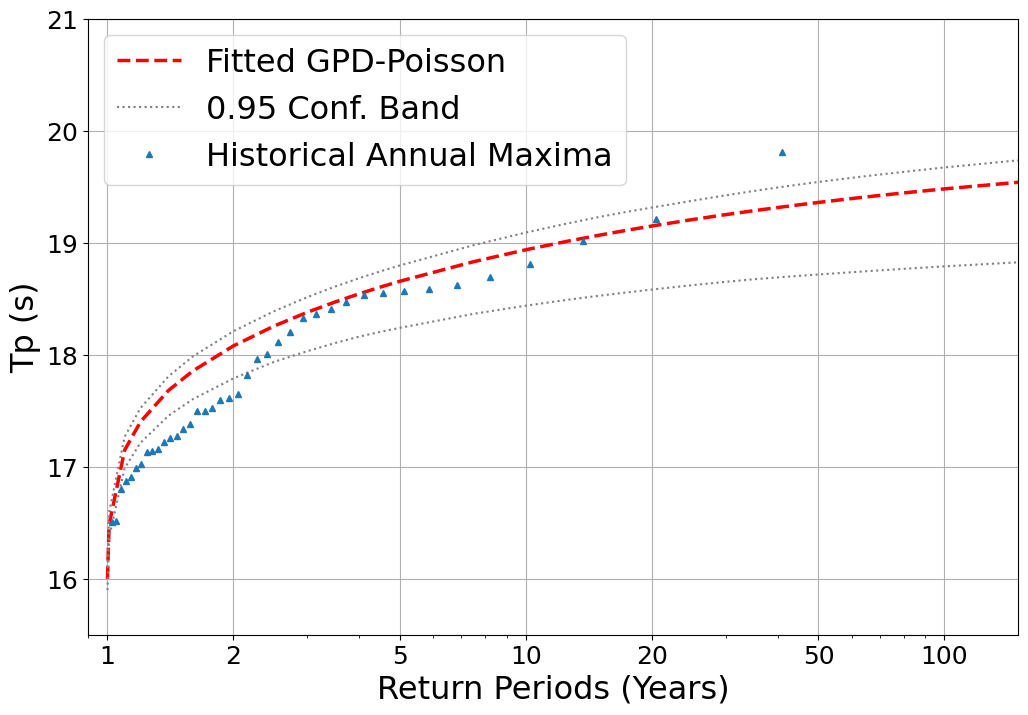

In [74]:
extr_corr_complete_tp.apply_correction(fit_diag=True)
fig, ax = extr_corr_complete_tp.return_period_plot()
ax.set_ylim(15.5, 21)
ax.set_xlim(0.9,150)
ax.set_ylabel("Tp (s)", fontsize=23)
ax.set_xlabel("Return Periods (Years)", fontsize=23)
ax.legend(loc = "upper left", fontsize=23)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
plt.savefig("Figures/Santona/Hs_Santona_Tp/Tp_Historical_ReturnPeriod.png", dpi=300, bbox_inches="tight")
plt.show()

In [35]:
extr_corr_complete_tp.test_dist()

{'Statistic': 33.31935038558424, 'P-value': 4.044957591098353e-09}

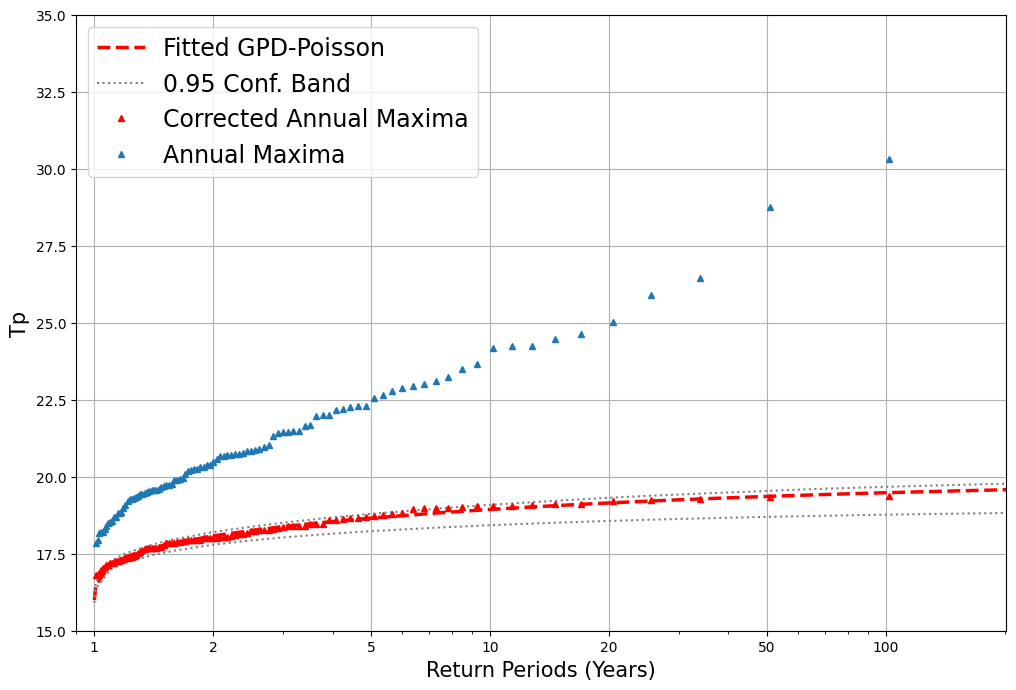

In [36]:
extr_corr_complete_tp.apply_sim_correction()
fig, ax = extr_corr_complete_tp.sim_return_period_plot(show_corrected=True, show_uncorrected=True)
# extr_corr_complete_tp.sim_return_period_plot(show_corrected=True, show_uncorrected=False)
# extr_corr_complete_tp.sim_return_period_plot(show_corrected=False, show_uncorrected=True)

ax.set_ylim(15, 35)
plt.savefig("Figures/Santona/Hs_Santona_Tp/Tp_Simulation_ReturnPeriod_Corr_NoCorr.png", dpi=300, bbox_inches="tight")
plt.show()

In [37]:
extr_corr_complete_tp.parameters

[13.119243621826172, 2.2173392137448147, -0.3243000767833937]

In [38]:
extr_corr_complete_tp.poiss_parameter, extr_corr_complete_tp.sim_poiss_parameter

(37.25, 51.81223231227975)

In [39]:
extr_corr_complete_tp.sim_poiss_parameter/ extr_corr_complete_tp.poiss_parameter

1.3909324110679127

## Loop over correction

In [40]:
dict_maximos_corregidos_Tp = {}
dict_sim_pit_corrected_Tp = {}
for i in range(100):
    
    extr_corr_complete_tp.apply_sim_correction(random_state=i)   # Apply the correction in the simulated data
    # if i == 0:
    #     extr_corr.sim_return_period_plot(show_corrected=True, show_uncorrected=True)                        # Default to plot the corrected and no corrected data
    #     fitted_gev = extr_corr.
    
    dict_maximos_corregidos_Tp[i] = extr_corr_complete_tp.sim_max_data_corrected_sorted
    dict_sim_pit_corrected_Tp[i] = extr_corr_complete_tp.sim_pit_data_corrected

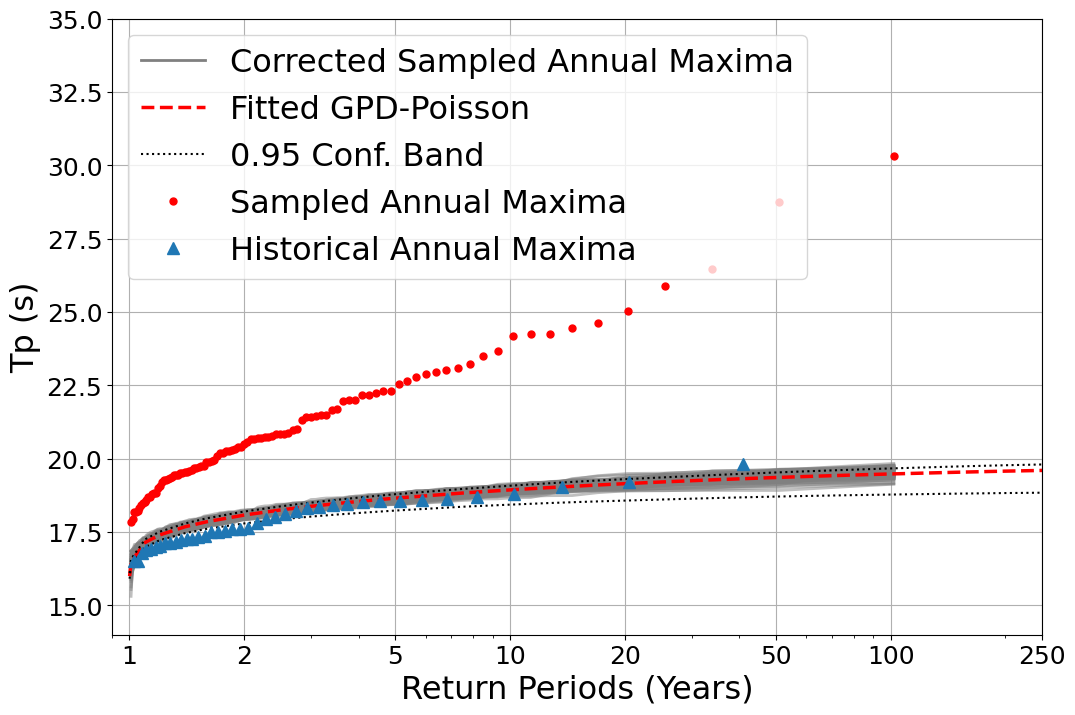

In [71]:
# import numdifftools as ndt
# from src.gev_utils import dq_gev, nll_gev
from src.constants import LABEL_FONTSIZE, LEGEND_FONTSIZE
# # Plot

# x_vals_gev_sim = np.linspace(stats.genextreme.ppf(1e-8, extr_corr.parameters[2], loc=extr_corr.parameters[0], scale=extr_corr.parameters[1]), stats.genextreme.ppf(1-1/1000, extr_corr.parameters[2], loc=extr_corr.parameters[0], scale=extr_corr.parameters[1]), 1000)
# # Return period from GEV fitted
# gev_probs_fitted = stats.genextreme.cdf(x_vals_gev_sim, extr_corr.parameters[2], loc=extr_corr.parameters[0], scale=extr_corr.parameters[1])
# T_gev_fitted = 1.0 / (1.0 - gev_probs_fitted) #*(40/len(max_data_hist[wt]))#(10000/n_peaks)

# # Corrected peaks: re-check CDF and return periods
# ecdf_annmax_probs_corrected_sim = stats.genextreme.cdf(
#     stats.genextreme.ppf(extr_corr.ecdf_annmax_probs_sim, extr_corr.parameters[2], loc=extr_corr.parameters[0], scale=extr_corr.parameters[1]),
#     extr_corr.parameters[2], loc=extr_corr.parameters[0], scale=extr_corr.parameters[1]
# )
# T_ev_corrected_sim = 1.0 / (1.0 - ecdf_annmax_probs_corrected_sim) #*(40/len(max_data_hist[wt]))#(10000/n_peaks)

# # Daily corrected data
# ecdf_pt_probs_corrected_sim = np.arange(1, extr_corr.n_sim_pit + 1) / (extr_corr.n_sim_pit + 1)
# T_pt_corrected_sim = 1.0 / (1.0 - ecdf_pt_probs_corrected_sim) / extr_corr.freq #/ n_return_period[wt] 

# # POT (uncorrected)
# T_pot_sim = 1.0 / (1.0 - extr_corr.ecdf_annmax_probs_sim) #*(40/len(max_data_hist[wt]))#(10000/n_peaks)

# # Confidence intervals
# dqgev_sim = dq_gev(gev_probs_fitted, p=[extr_corr.parameters[0], extr_corr.parameters[1], extr_corr.parameters[2]])
# aux_fun = lambda x: nll_gev(extr_corr.max_data, x)
# hess = ndt.Hessian(aux_fun, step=1e-4)  # Añado el step para que no de problemas de inestabilidad
# hessians_gev_sim = hess([extr_corr.parameters[0], extr_corr.parameters[1], extr_corr.parameters[2]])
# invI0_gev_sim = np.linalg.inv(hessians_gev_sim)

# stdDq_gev_sim = np.sqrt(np.sum((dqgev_sim.T@invI0_gev_sim) * dqgev_sim.T, axis=1)) # Es lo mismo 
# stdup_gev_sim = x_vals_gev_sim + stdDq_gev_sim*stats.norm.ppf(1-(1-extr_corr.conf)/2,0,1)
# stdlo_gev_sim = x_vals_gev_sim - stdDq_gev_sim*stats.norm.ppf(1-(1-extr_corr.conf)/2,0,1)


fig = plt.figure(figsize=(12,8))
ax= fig.add_subplot()

# Corrected AM
ax.semilogx(extr_corr_complete_tp.T_annmax_sim, dict_maximos_corregidos_Tp[0], color = 'gray', linewidth=2, alpha=0.5,label='Corrected Sampled Annual Maxima')
for i in range(1,100):
    ax.semilogx(extr_corr_complete_tp.T_annmax_sim, dict_maximos_corregidos_Tp[i], color = 'gray', linewidth=2, alpha=0.5)

# Fitted GPD-Poisson
ax.semilogx(extr_corr_complete_tp.ci_T_years, extr_corr_complete_tp.x_vals_gpd_poiss_hist, color = 'red',linestyle='dashed', linewidth=2.5, label='Fitted GPD-Poisson')
# Confidence interval for fitted GPD-Poisson
ax.semilogx(extr_corr_complete_tp.ci_T_years, extr_corr_complete_tp.upper_pot_ci_return, color = "black",linestyle='dotted', label=f'{extr_corr_complete_tp.conf} Conf. Band')
ax.semilogx(extr_corr_complete_tp.ci_T_years, extr_corr_complete_tp.lower_pot_ci_return, color = "black",linestyle='dotted')


ax.semilogx(extr_corr_complete_tp.T_annmax_sim, extr_corr_complete_tp.sim_max_data_sorted, color="red", linewidth=0, marker='o',markersize=5, label='Sampled Annual Maxima')

ax.semilogx(extr_corr_complete_tp.T_annmax, extr_corr_complete_tp.max_data_sorted, color="tab:blue", linewidth=0, marker='^',markersize=8, label='Historical Annual Maxima')

ax.set_xlabel("Return Periods (Years)", fontsize=23)
ax.set_ylabel(f"{extr_corr_complete_tp.var} (s)", fontsize=23)
# ax.set_title(f"Simulated Return Period ({self.var})", fontsize=TITLE_FONTSIZE)
ax.set_xscale('log')
ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
ax.set_xlim(left=0.9,right=250)
ax.set_ylim(bottom=14, top=35)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
leg = ax.legend(loc='best', ncol=1, fontsize=23)
for lh in leg.legend_handles:
    lh.set_alpha(1)
# ax.legend(loc='upper left', fontsize=LEGEND_FONTSIZE)
ax.grid()
plt.savefig("Figures/Santona/Hs_Santona_Tp/Tp_ReturnPeriod_Simulated_100sims.png", dpi=300, bbox_inches="tight")
plt.show()

In [42]:
extr_corr_complete_tp.correlation()

{'Spearman': 0.9999999999999998, 'Kendall': 1.0, 'Pearson': 0.9990594016031273}

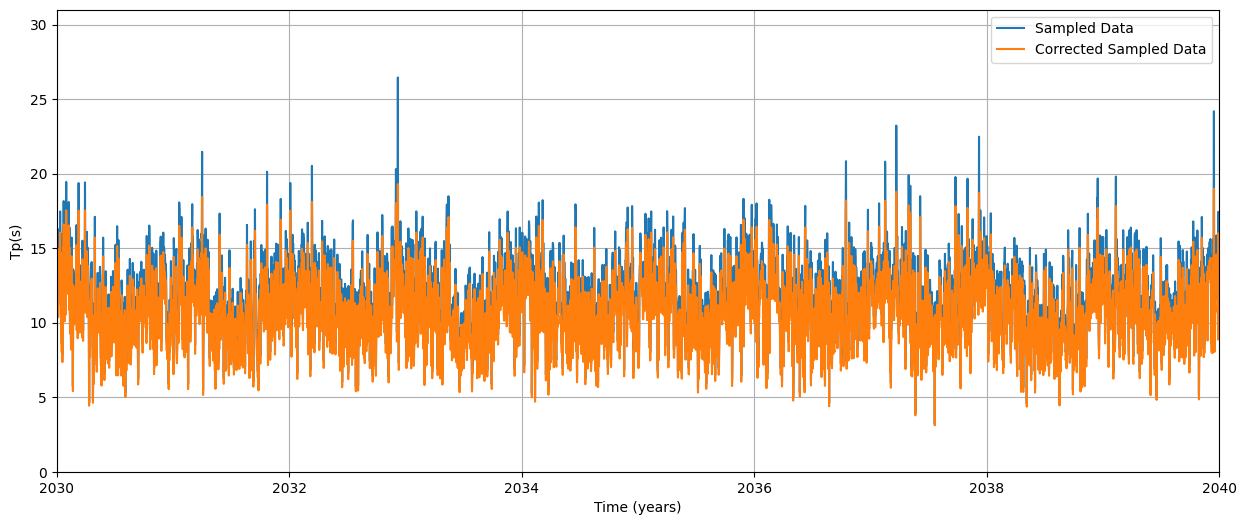

In [43]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot()

ax.plot(df_sim["time"].values[:-1]+df_sim["yyyy"].min(), extr_corr_complete_tp.sim_pit_data, label="Sampled Data")
ax.plot(df_sim["time"].values[:-1]+df_sim["yyyy"].min(), extr_corr_complete_tp.sim_pit_data_corrected, label="Corrected Sampled Data")
ax.set_xlim(2030, 2040)
ax.set_ylim(0, 31)
ax.set_xlabel("Time (years)")
ax.set_ylabel("Tp(s)")
ax.grid()
ax.legend()
plt.savefig("Figures/Santona/Hs_Santona_Tp/Tp_SimTimeSeries_Corr_NoCorr.png", dpi=300, bbox_inches="tight")
plt.show()

## Simulated Poisson parameter change between simulations

In [44]:
sim_poiss_param_100_tp = np.zeros(100)
for i in range(100):
    sim_pot_corrected_tp, _ = extr_corr_complete_tp.obtain_pots(
                dict_sim_pit_corrected_Tp[i],
                threshold=extr_corr_complete_tp.opt_threshold,
                n0 = extr_corr_complete_tp.pot_config['n0'],
                min_peak_distance=extr_corr_complete_tp.pot_config['min_peak_distance'],
                siglevel = extr_corr_complete_tp.pot_config['siglevel'],
                plot_flag = extr_corr_complete_tp.pot_config['plot_flag'],
                optimize_threshold=False
            )
    sim_poiss_param_100_tp[i] = sim_pot_corrected_tp.size / extr_corr_complete_tp.time_interval_sim

In [45]:
print(np.mean(sim_poiss_param_100_tp), np.std(sim_poiss_param_100_tp))

35.961629845486584 3.292205142498081


In [46]:
extr_corr_complete_tp.sim_poiss_parameter

51.81223231227975

In [47]:
extr_corr_complete_tp.poiss_parameter

37.25

In [48]:
bloques = {}
for j in range(extr_corr_complete_tp.sim_max_data_sorted.size):
    if j == 0:
        bloques[j] = (
            sum((extr_corr_complete_tp.sim_pit_data >= min(extr_corr_complete_tp.sim_pit_data)) & (extr_corr_complete_tp.sim_pit_data < extr_corr_complete_tp.sim_max_data_sorted[j])), 
            (min(extr_corr_complete_tp.sim_pit_data), extr_corr_complete_tp.sim_max_data_sorted[j]), 
            (min(extr_corr_complete_tp.sim_pit_data_corrected), extr_corr_complete_tp.sim_max_data_corrected_sorted[j])
            )
    else:
        bloques[j] = (
            sum((extr_corr_complete_tp.sim_pit_data >= extr_corr_complete_tp.sim_max_data_sorted[j-1]) & (extr_corr_complete_tp.sim_pit_data < extr_corr_complete_tp.sim_max_data_sorted[j])), 
            (extr_corr_complete_tp.sim_max_data_sorted[j-1], extr_corr_complete_tp.sim_max_data_sorted[j]), 
            (extr_corr_complete_tp.sim_max_data_corrected_sorted[j-1], extr_corr_complete_tp.sim_max_data_corrected_sorted[j])
            )

In [49]:
bloques

{0: (36484,
  (2.3518926411971, 17.850811503524792),
  (2.3518926411971, 16.38524897445351)),
 1: (41,
  (17.850811503524792, 17.956235225790262),
  (16.38524897445351, 16.394667765762463)),
 2: (63,
  (17.956235225790262, 18.175428787397607),
  (16.394667765762463, 16.601002776049985)),
 3: (3,
  (18.175428787397607, 18.19710327573736),
  (16.601002776049985, 16.793037839585267)),
 4: (4,
  (18.19710327573736, 18.220296343180422),
  (16.793037839585267, 16.87958957148215)),
 5: (16,
  (18.220296343180422, 18.311216434209072),
  (16.87958957148215, 16.91512705374742)),
 6: (16,
  (18.311216434209072, 18.40768419150487),
  (16.91512705374742, 16.930135159872545)),
 7: (13,
  (18.40768419150487, 18.48547739319836),
  (16.930135159872545, 17.088800928288922)),
 8: (8,
  (18.48547739319836, 18.538906402633486),
  (17.088800928288922, 17.09547301593588)),
 9: (4,
  (18.538906402633486, 18.577365591007776),
  (17.09547301593588, 17.158758103599688)),
 10: (21,
  (18.577365591007776, 18.68692

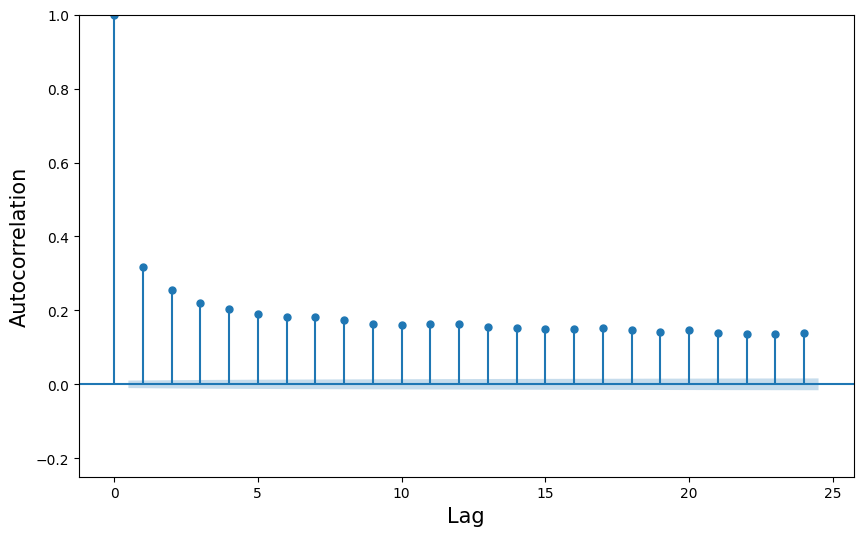

In [50]:
plt.rc("figure", figsize=(10,6))
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
plot_acf(extr_corr_complete_tp.sim_pit_data, ax=ax, lags=24, alpha=0.05)
ax.set_title("")
ax.set_xlabel("Lag", fontsize=15)
ax.set_ylabel("Autocorrelation", fontsize=15)
ax.set_ylim(-0.25)
plt.savefig("Figures/Santona/Hs_Santona_Tp/Tp_ACF_sim.png", dpi=300, bbox_inches='tight')
plt.show()

In [51]:
acf_hist, confint_hist = acf(extr_corr_complete_tp.sim_pit_data, nlags=7, alpha=0.05)
acf_sim, confint_sim = acf(extr_corr_complete_tp.sim_pit_data_corrected, nlags=7, alpha=0.05)

In [52]:
stats.pearsonr(acf_hist, acf_sim)

PearsonRResult(statistic=0.9999978122136992, pvalue=2.6179056586425314e-17)

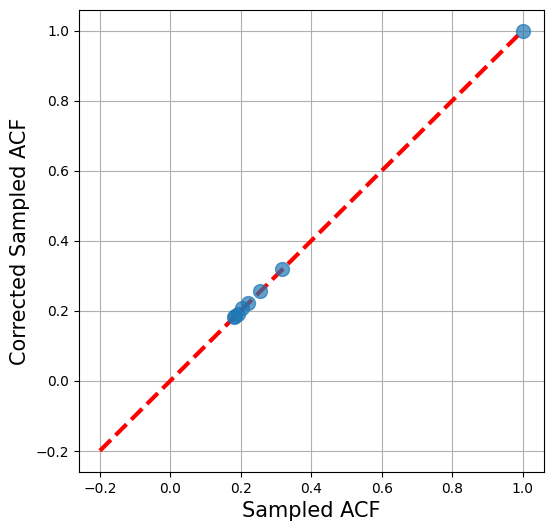

In [53]:
plt.figure(figsize=(6,6))
plt.plot([-0.2,1],[-0.2,1], 'r--', linewidth=3)
plt.plot(acf_hist, acf_sim, linewidth=0, marker="o", markersize=10, alpha=0.7)
plt.grid()
plt.xlabel("Sampled ACF", fontsize=15)
plt.ylabel("Corrected Sampled ACF", fontsize=15)
plt.savefig("Figures/Santona/Hs_Santona_Tp/Tp_ACF_scatter.png", dpi=300, bbox_inches='tight')
plt.show()

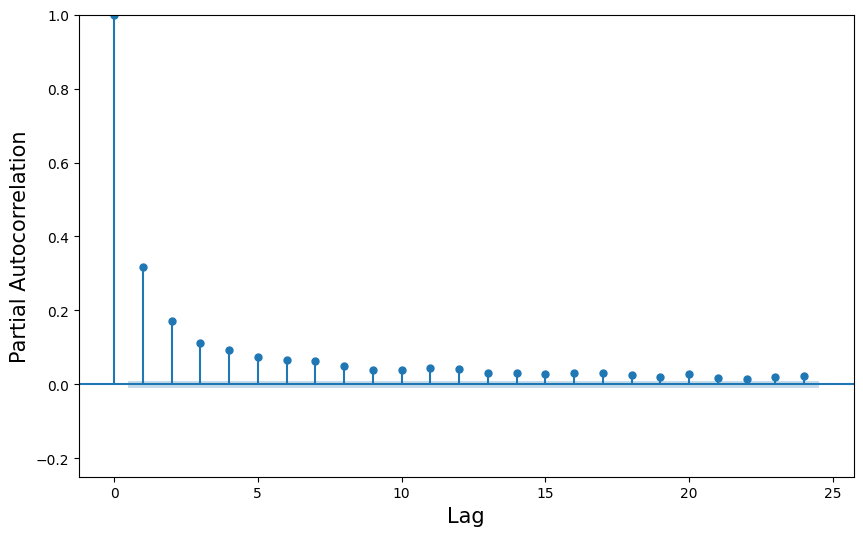

In [54]:
plt.rc("figure", figsize=(10,6))
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
plot_pacf(extr_corr_complete_tp.sim_pit_data, ax=ax, lags=24, alpha=0.05)
ax.set_title("")
ax.set_xlabel("Lag", fontsize=15)
ax.set_ylabel("Partial Autocorrelation", fontsize=15)
ax.set_ylim(-0.25)
plt.savefig("Figures/Santona/Hs_Santona_Tp/Tp_PACF_sim.png", dpi=300, bbox_inches='tight')
plt.show()

In [55]:
pacf_hist, pconfint_hist = pacf(extr_corr_complete_tp.sim_pit_data, nlags=7, alpha=0.05)
pacf_sim, pconfint_sim = pacf(extr_corr_complete_tp.sim_pit_data_corrected, nlags=7, alpha=0.05)

In [56]:
stats.pearsonr(pacf_hist, pacf_sim)

PearsonRResult(statistic=0.9999956500333417, pvalue=2.05776784399759e-16)

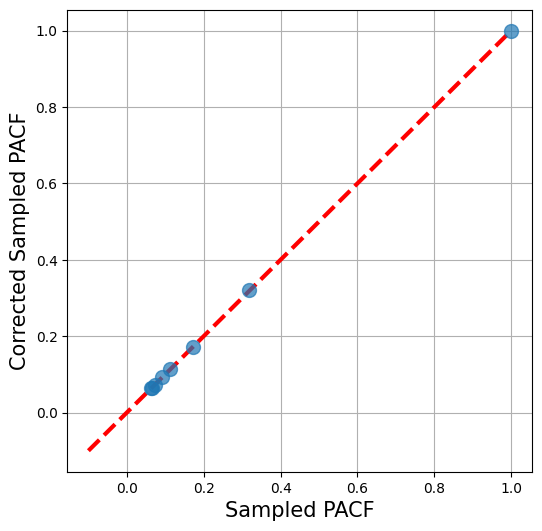

In [57]:
plt.figure(figsize=(6,6))
plt.plot([-0.1,1],[-0.1,1], 'r--', linewidth=3)
plt.plot(pacf_hist, pacf_sim, linewidth=0, marker="o", markersize=10, alpha=0.7)
plt.grid()
plt.xlabel("Sampled PACF", fontsize=15)
plt.ylabel("Corrected Sampled PACF", fontsize=15)
plt.savefig("Figures/Santona/Hs_Santona_Tp/Tp_PACF_scatter.png", dpi=300, bbox_inches='tight')
plt.show()

# Correlation between series

In [58]:
spear_corr_before= stats.spearmanr(extr_corr_complete.sim_pit_data, extr_corr_complete_tp.sim_pit_data)[0]
spear_corr_after = stats.spearmanr(extr_corr_complete.sim_pit_data_corrected, extr_corr_complete_tp.sim_pit_data_corrected)[0]
kendall_corr_before= stats.kendalltau(extr_corr_complete.sim_pit_data, extr_corr_complete_tp.sim_pit_data)[0]
kendall_corr_after= stats.kendalltau(extr_corr_complete.sim_pit_data_corrected, extr_corr_complete_tp.sim_pit_data_corrected)[0]
pearson_corr_before= stats.pearsonr(extr_corr_complete.sim_pit_data, extr_corr_complete_tp.sim_pit_data)[0]
pearson_corr_after= stats.pearsonr(extr_corr_complete.sim_pit_data_corrected, extr_corr_complete_tp.sim_pit_data_corrected)[0]

print(f"Spearman {spear_corr_before} -> {spear_corr_after}")
print(f"Kendall {kendall_corr_before} -> {kendall_corr_after}")
print(f"Pearson {pearson_corr_before} -> {pearson_corr_after}")

Spearman 0.531681781803654 -> 0.531681781803654
Kendall 0.3707662987350247 -> 0.3707662987350247
Pearson 0.5066222650234152 -> 0.5201159649329381
